In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss
from train_test import train_model
from train_test import evaluate_model
from train_test import evaluate_model_sr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
ds_HR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 
ds_LR = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_LR_southAtlantic_every10TimeSteps_20Yrs.zarr", engine="zarr", chunks={}
) 

In [4]:
# Select region of interest
ds_HR_reg = ds_HR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))
ds_LR_reg = ds_LR.isel(xt_ocean=slice(1100,1300), yt_ocean=slice(1500,1800))

In [5]:
# Total number of samples
n_samples = len(ds_HR_reg.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = ds_HR_reg.isel(time=train_indices)
val_data_HR = ds_HR_reg.isel(time=val_indices)
test_data_HR = ds_HR_reg.isel(time=test_indices)
# LR
train_data_LR = ds_LR_reg.isel(time=train_indices)
val_data_LR = ds_LR_reg.isel(time=val_indices)
test_data_LR = ds_LR_reg.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 511
Validation set size: 109
Testing set size: 111


# Case: t_ref Kelvin Case

In [6]:
# Extract HR data
HR_train = train_data_HR.t_ref.values ## training
HR_val = val_data_HR.t_ref.values ## validation
HR_test = test_data_HR.t_ref ## testing

# Extract LR data
LR_train = train_data_LR.t_ref.values ## training
LR_val = val_data_LR.t_ref.values ## validation
LR_test = test_data_LR.t_ref.values ## testing

In [7]:
x_train = torch.tensor(LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [8]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [12]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [14]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_checker_tref.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 31 with best val losses [78940.39506880734]
Epoch 32, Train Loss: 7.951e+04, Val Loss: 7.914e+04, Epoch Time: 138.73s
Epoch 33, Train Loss: 7.938e+04, Val Loss: 7.911e+04, Epoch Time: 138.97s
Epoch 34, Train Loss: 7.925e+04, Val Loss: 7.914e+04, Epoch Time: 138.57s
Epoch 35, Train Loss: 7.911e+04, Val Loss: 7.873e+04, Epoch Time: 137.51s
Best model so far saved to ./model_checker_tref.pth
Epoch 36, Train Loss: 7.898e+04, Val Loss: 7.857e+04, Epoch Time: 138.29s
Best model so far saved to ./model_checker_tref.pth
Epoch 37, Train Loss: 7.884e+04, Val Loss: 7.866e+04, Epoch Time: 137.96s
Epoch 38, Train Loss: 7.869e+04, Val Loss: 7.816e+04, Epoch Time: 138.92s
Best model so far saved to ./model_checker_tref.pth
Epoch 39, Train Loss: 7.855e+04, Val Loss: 7.806e+04, Epoch Time: 138.92s
Best model so far saved to ./model_checker_tref.pth
Epoch 40, Train Loss: 7.840e+04, Val Loss: 7.793e+04, Epoch Time: 138.90s
Best model so far saved to ./mod

In [10]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_checker_tref.pth')
sr_pred

Loaded model parameters from ./model_checker_tref.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[11.919411 , 13.41428  , 14.273751 , ...,  9.452501 ,
          9.834553 ,  8.913643 ],
        [ 8.060206 ,  8.134629 , 12.757124 , ...,  9.686477 ,
         10.432627 ,  7.941487 ],
        [10.232119 , 12.932688 , 10.218168 , ..., 10.016093 ,
         10.2223015,  7.6127334],
        ...,
        [ 7.7034674, 10.367205 , 10.81307  , ...,  2.6611242,
          2.9436784,  3.2983284],
        [10.6578245,  8.063432 ,  8.919202 , ...,  5.334113 ,
          5.016365 ,  2.790679 ],
        [ 5.4841375,  9.31649  ,  8.562616 , ...,  8.189165 ,
          6.4210634,  5.6839356]],

       [[12.005108 , 13.542423 , 14.394295 , ...,  9.461773 ,
          9.928875 ,  9.004433 ],
        [ 8.195096 ,  8.222815 , 12.873177 , ...,  9.754376 ,
         10.636362 ,  8.18739  ],
        [10.34695  , 12.999689 , 10.319811 , ..., 10.204652 ,
         10.485614 ,  7.844794 ],
...
        [ 7.6956873, 10.3528185, 10.897733 , ...,  2.646307 ,
          2.9476569,  3.2859795],
        [10.601236 ,  7.99496  ,  8.865728 , ...,  5.362649 ,
          5.033239 ,  2.7684066],
        [ 5.4427648,  9.247519 ,  8.497143 , ...,  8.266987 ,
          6.4735394,  5.7125287]],

       [[11.983452 , 13.512782 , 14.368001 , ...,  9.464353 ,
          9.937328 ,  9.014739 ],
        [ 8.159904 ,  8.199659 , 12.842469 , ...,  9.758959 ,
         10.653547 ,  8.206174 ],
        [10.314407 , 12.9788475, 10.290883 , ..., 10.218424 ,
         10.505527 ,  7.8627796],
        ...,
        [ 7.694557 , 10.377549 , 10.889761 , ...,  3.328924 ,
          3.2832417,  2.6710181],
        [10.612027 ,  8.011323 ,  8.871208 , ...,  5.7281456,
          5.366071 ,  2.5863075],
        [ 5.4499125,  9.247772 ,  8.499933 , ...,  8.339699 ,
          6.17418  ,  5.2666454]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0195-12-04 12:00:00 ... 0199-10-14 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

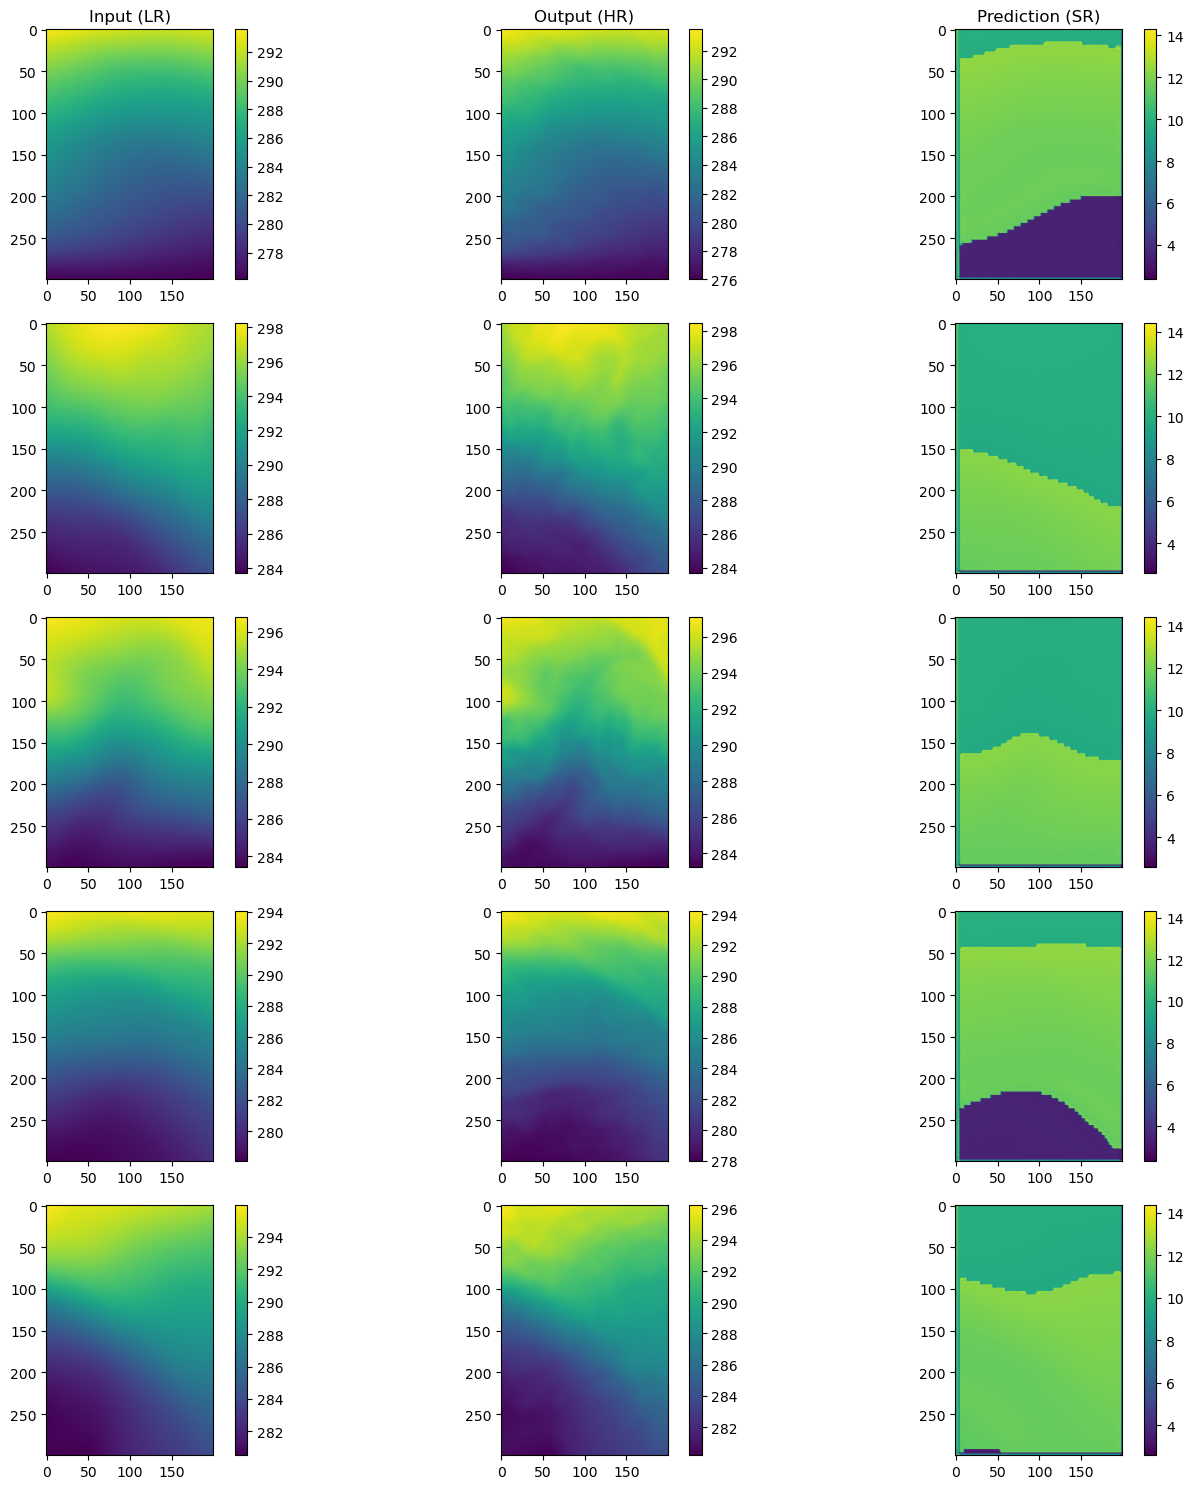

In [11]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = LR_test[i,:,:] 
    d2 = HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis') #, vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis') #, vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis')
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

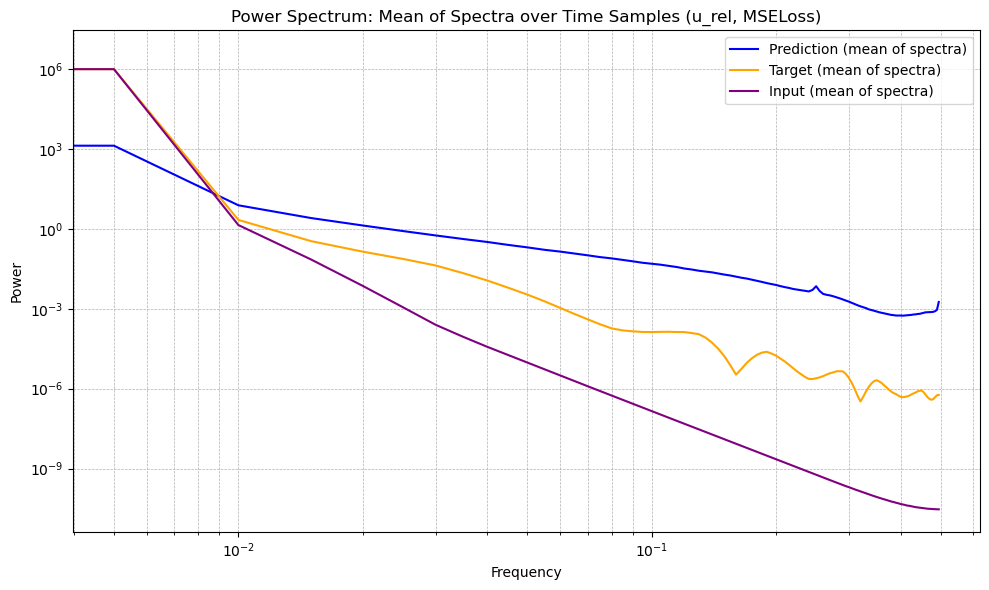

In [13]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(HR_test, dims, coords)
ps_input = mean_spectrum_over_samples(LR_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')
plt.plot(ps_input.freq_xt_ocean, ps_input, label='Input (mean of spectra)', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (t_ref Kelvin, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Case: t_ref Celcius case

In [6]:
# Extract HR data
HR_train = train_data_HR.t_ref.values - 273.15 ## training
HR_val = val_data_HR.t_ref.values - 273.15 ## validation
HR_test = test_data_HR.t_ref - 273.15 ## testing

# Extract LR data
LR_train = train_data_LR.t_ref.values - 273.15 ## training
LR_val = val_data_LR.t_ref.values - 273.15 ## validation
LR_test = test_data_LR.t_ref.values - 273.15 ## testing

In [7]:
x_train = torch.tensor(LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [8]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, torch.zeros(len(x_test)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_celcius_tref.pth',
            n_epochs=100) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 71 with best val losses [0.047708421774687024, 0.04660343559920241, 0.05287124288328197, 0.04439067314250754, 0.04428675394812855]
Epoch 72, Train Loss: 2.506e-01, Val Loss: 7.426e-02, Epoch Time: 139.19s
Patience counter: 1/50
Epoch 73, Train Loss: 3.635e-01, Val Loss: 3.429e-01, Epoch Time: 163.68s
Patience counter: 2/50
Epoch 74, Train Loss: 3.316e-01, Val Loss: 5.614e-02, Epoch Time: 180.83s
Patience counter: 3/50
Epoch 75, Train Loss: 3.129e-01, Val Loss: 2.504e-01, Epoch Time: 165.81s
Patience counter: 4/50
Epoch 76, Train Loss: 3.986e-01, Val Loss: 6.391e-02, Epoch Time: 136.81s
Patience counter: 5/50
Epoch 77, Train Loss: 2.929e-01, Val Loss: 4.341e-02, Epoch Time: 136.83s
Best model so far saved to ./model_celcius_tref.pth
Epoch 78, Train Loss: 2.626e-01, Val Loss: 6.597e-02, Epoch Time: 137.05s
Patience counter: 1/50
Epoch 79, Train Loss: 2.100e-01, Val Loss: 3.675e-02, Epoch Time: 141.46s
Best model so far saved to ./model_ce

In [18]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_celcius_tref.pth')
sr_pred

Loaded model parameters from ./model_celcius_tref.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[20.955076  , 20.57129   , 20.093267  , ..., 19.831633  ,
         19.512768  , 18.408016  ],
        [20.336742  , 20.195963  , 20.60383   , ..., 19.339613  ,
         20.038105  , 19.211075  ],
        [20.5829    , 20.612669  , 19.69952   , ..., 19.66053   ,
         19.638918  , 20.189528  ],
        ...,
        [ 3.7561882 ,  3.3810673 ,  3.560089  , ...,  3.0330942 ,
          3.685685  ,  3.880797  ],
        [ 4.164378  ,  3.3224592 ,  3.472061  , ...,  3.475181  ,
          4.550062  ,  4.072696  ],
        [ 3.913183  ,  3.2645173 ,  3.647611  , ...,  3.7068548 ,
          4.452338  ,  4.7475553 ]],

       [[23.970295  , 23.450552  , 23.68335   , ..., 23.495188  ,
         22.57479   , 20.715992  ],
        [23.989305  , 24.405584  , 25.088102  , ..., 23.151579  ,
         23.69554   , 22.548292  ],
        [24.61488   , 24.79003   , 23.344473  , ..., 23.911022  ,
         23.75026   , 23.82848   ],
...
        [ 3.5697656 ,  3.1601753 ,  3.2595773 , ...,  4.2244334 ,
          4.7605515 ,  4.7337346 ],
        [ 4.0145183 ,  3.112492  ,  3.2057934 , ...,  4.6253724 ,
          5.43857   ,  4.7704725 ],
        [ 3.7849708 ,  3.0395625 ,  3.364935  , ...,  4.6855135 ,
          5.1934295 ,  5.3609686 ]],

       [[23.21944   , 22.7378    , 22.80653   , ..., 23.839928  ,
         22.878761  , 20.927845  ],
        [23.073586  , 23.407488  , 23.998343  , ..., 23.48564   ,
         24.0437    , 22.842543  ],
        [23.61256   , 23.779003  , 22.455635  , ..., 24.326788  ,
         24.162928  , 24.14819   ],
        ...,
        [ 3.7903714 ,  3.3730195 ,  3.5520241 , ..., 10.218338  ,
         10.48135   , 10.105103  ],
        [ 4.1822553 ,  3.3301988 ,  3.484743  , ..., 10.386802  ,
          9.625305  ,  8.850474  ],
        [ 3.8954544 ,  3.2545767 ,  3.6346266 , ..., 10.923371  ,
         10.736332  ,  8.480138  ]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0195-12-04 12:00:00 ... 0199-10-14 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

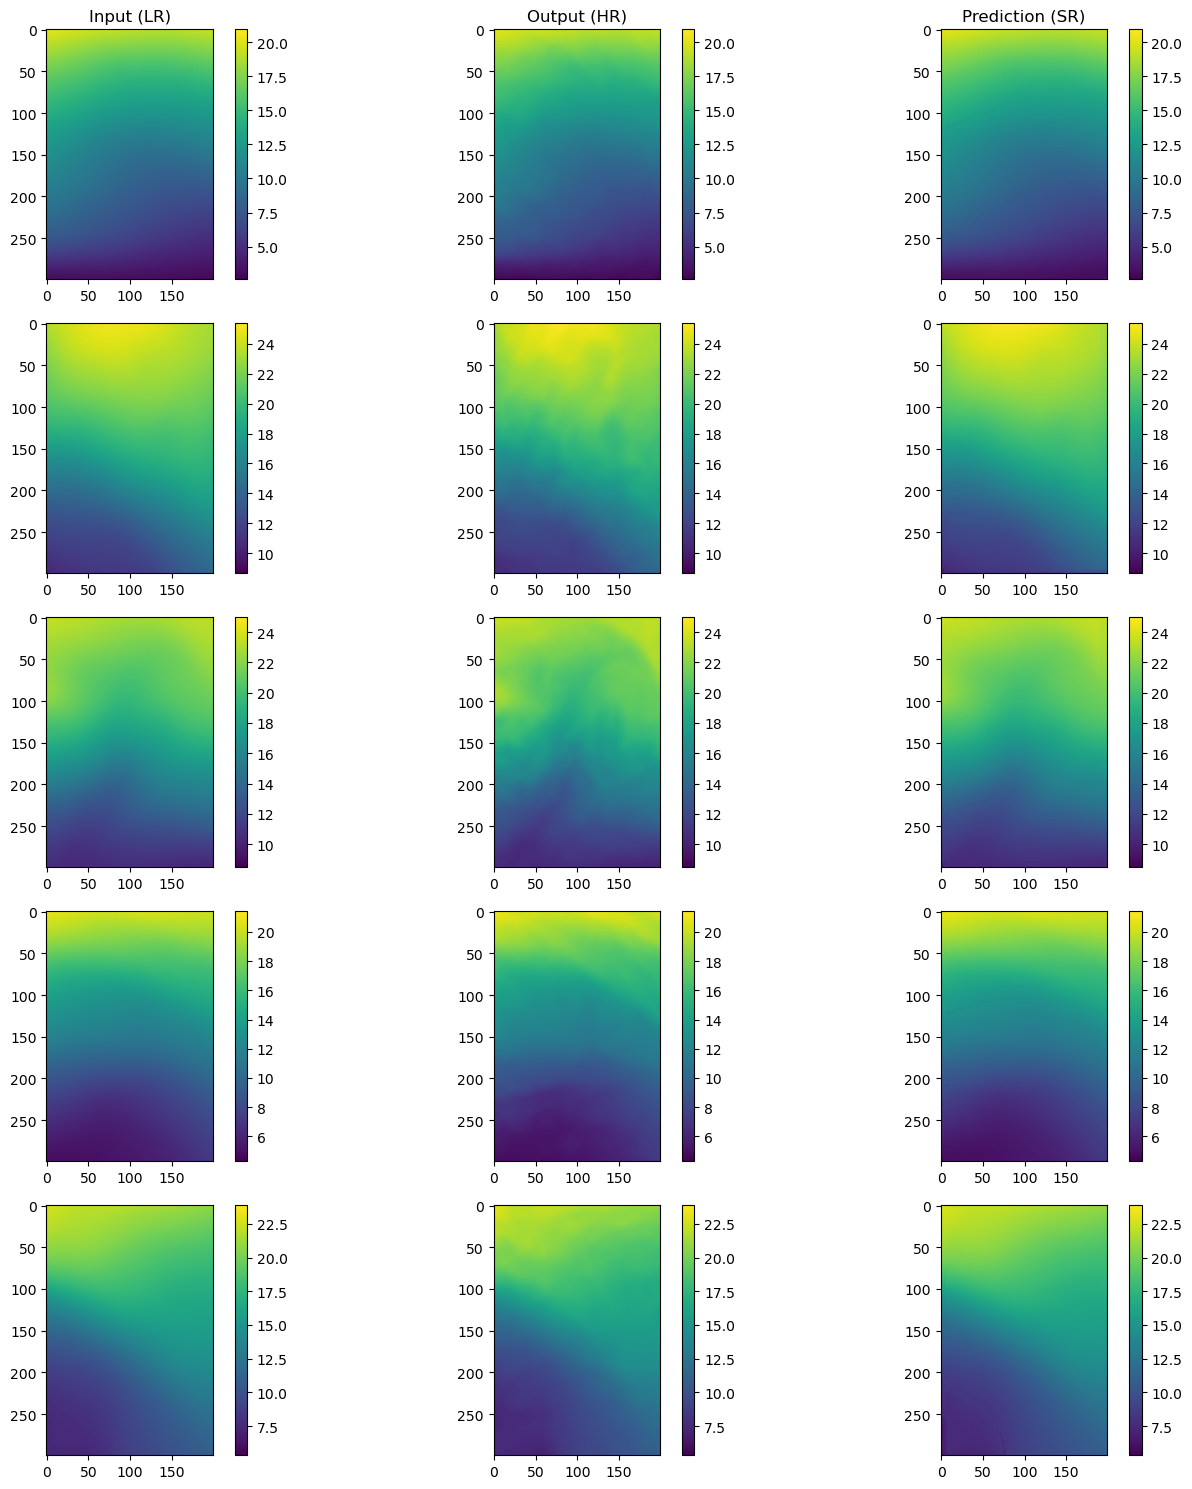

In [19]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = LR_test[i,:,:] 
    d2 = HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

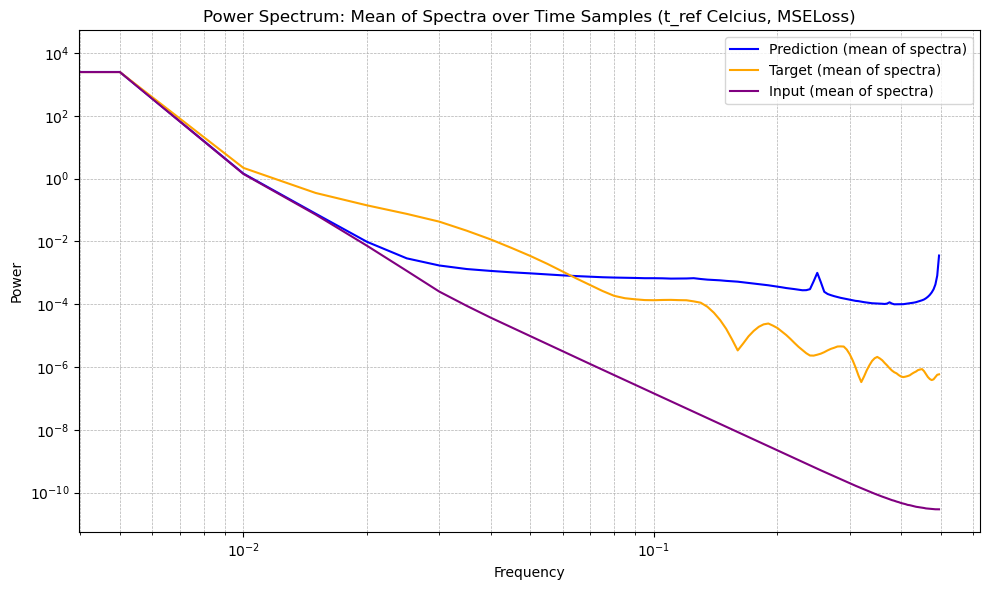

In [20]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(HR_test, dims, coords)
ps_input = mean_spectrum_over_samples(LR_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')
plt.plot(ps_input.freq_xt_ocean, ps_input, label='Input (mean of spectra)', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (t_ref Celcius, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Case: SST in Kelvin

In [9]:
# Extract HR data
HR_train = train_data_HR.surface_temp.values ## training
HR_val = val_data_HR.surface_temp.values ## validation
HR_test = test_data_HR.surface_temp ## testing

# Extract LR data
LR_train = train_data_LR.surface_temp.values ## training
LR_val = val_data_LR.surface_temp.values ## validation
LR_test = test_data_LR.surface_temp.values ## testing

In [10]:
x_train = torch.tensor(LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [25]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_kelvin_sst.pth',
            n_epochs=50) # n_epochs=2000)

Trainable Parameters: 2314881
Epoch 1, Train Loss: 4.625e-01, Val Loss: 2.411e-01, Epoch Time: 281.65s
Model saved at epoch 1
Epoch 2, Train Loss: 3.593e-01, Val Loss: 1.769e-01, Epoch Time: 285.04s
Model saved at epoch 2
Epoch 3, Train Loss: 3.512e-01, Val Loss: 1.065e-01, Epoch Time: 285.57s
Model saved at epoch 3
Epoch 4, Train Loss: 4.215e-01, Val Loss: 1.384e-01, Epoch Time: 282.88s
Model saved at epoch 4
Epoch 5, Train Loss: 6.066e-01, Val Loss: 1.958e-01, Epoch Time: 191.86s
Model saved at epoch 5
Epoch 6, Train Loss: 5.707e-01, Val Loss: 2.455e-01, Epoch Time: 139.90s
Model saved at epoch 6
Epoch 7, Train Loss: 3.219e-01, Val Loss: 5.030e-02, Epoch Time: 139.40s
Model saved at epoch 7
Epoch 8, Train Loss: 2.850e-01, Val Loss: 2.204e-01, Epoch Time: 139.66s
Model saved at epoch 8
Epoch 9, Train Loss: 3.741e-01, Val Loss: 2.130e-01, Epoch Time: 139.61s
Model saved at epoch 9
Epoch 10, Train Loss: 4.936e-01, Val Loss: 9.434e-01, Epoch Time: 140.99s
Model saved at epoch 10
Epoch 11

In [13]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_kelvin_sst.pth')
sr_pred

Loaded model parameters from ./model_kelvin_sst.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[22.058971 , 22.055948 , 21.72507  , ..., 22.276867 ,
         21.149162 , 19.994246 ],
        [22.14027  , 22.161009 , 22.883312 , ..., 21.830929 ,
         22.199951 , 21.337336 ],
        [22.446354 , 22.616905 , 21.607088 , ..., 21.95163  ,
         21.9116   , 22.440123 ],
        ...,
        [ 7.9068284,  7.2863483,  7.677267 , ..., 10.286558 ,
          9.944147 , 10.178175 ],
        [ 7.468626 ,  6.93309  ,  7.4329214, ..., 10.2505455,
          9.618897 ,  9.147665 ],
        [ 6.9134264,  6.333567 ,  7.012188 , ..., 10.671823 ,
         10.557557 ,  8.657635 ]],

       [[20.524864 , 20.50585  , 19.836609 , ..., 22.542427 ,
         21.386456 , 20.16021  ],
        [20.443363 , 19.917446 , 20.5184   , ..., 22.091099 ,
         22.461138 , 21.539812 ],
        [20.518717 , 20.476307 , 19.654373 , ..., 22.214094 ,
         22.194176 , 22.677694 ],
...
        [ 8.568417 ,  8.454323 ,  8.232674 , ..., 11.185194 ,
         10.774983 , 11.071156 ],
        [ 8.81377  ,  8.3233795,  7.70203  , ..., 11.105529 ,
         10.401196 ,  9.82968  ],
        [ 8.641367 ,  8.531603 ,  8.915699 , ..., 11.267492 ,
         11.143569 ,  9.059723 ]],

       [[17.117659 , 17.620174 , 15.719797 , ..., 19.438189 ,
         19.013264 , 18.149368 ],
        [16.145338 , 15.33118  , 15.300153 , ..., 19.02187  ,
         19.538671 , 18.872335 ],
        [15.682625 , 16.038263 , 15.362499 , ..., 19.168217 ,
         19.228386 , 19.618486 ],
        ...,
        [ 4.1105285,  3.9668236,  4.1184225, ...,  3.4084132,
          3.6889248,  3.925518 ],
        [ 4.4224286,  4.04786  ,  4.0632863, ...,  3.7922955,
          4.3327103,  4.235531 ],
        [ 4.245179 ,  3.811351 ,  3.939707 , ...,  3.96996  ,
          4.4024334,  4.7742805]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0195-07-07 12:00:00 ... 0196-02-22 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

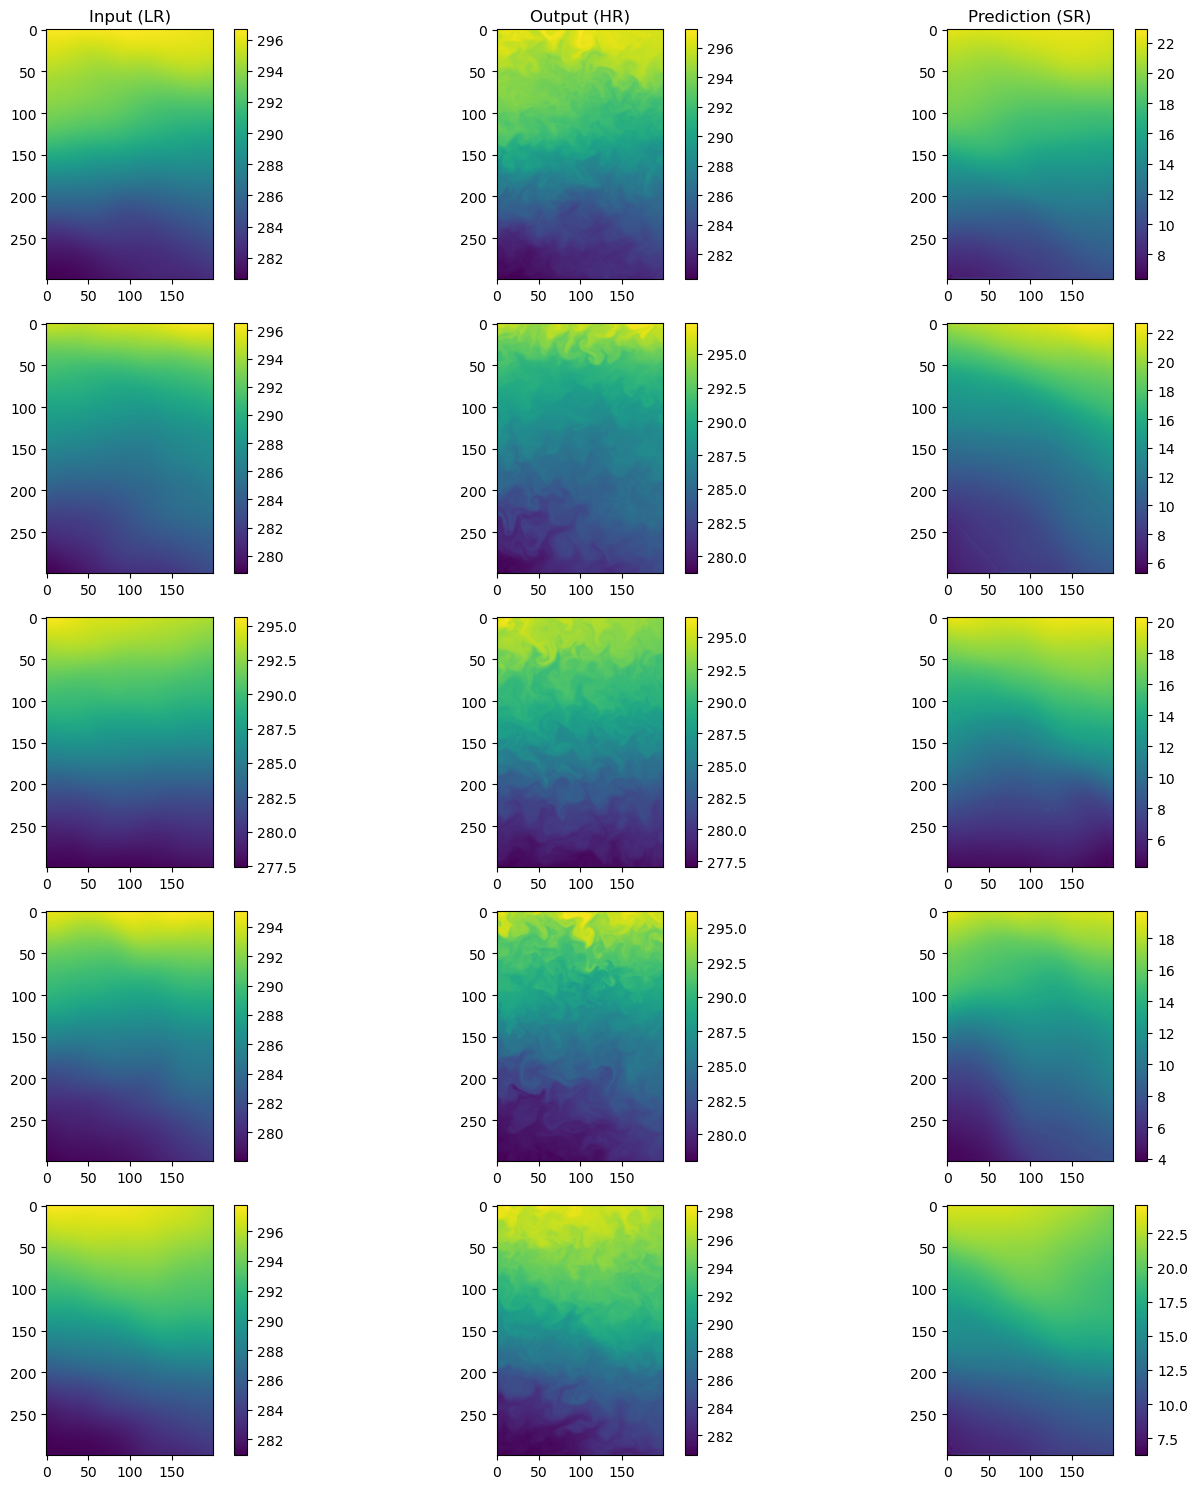

In [14]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = LR_test[i,:,:] 
    d2 = HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis') #, vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis') #, vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis') #, vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

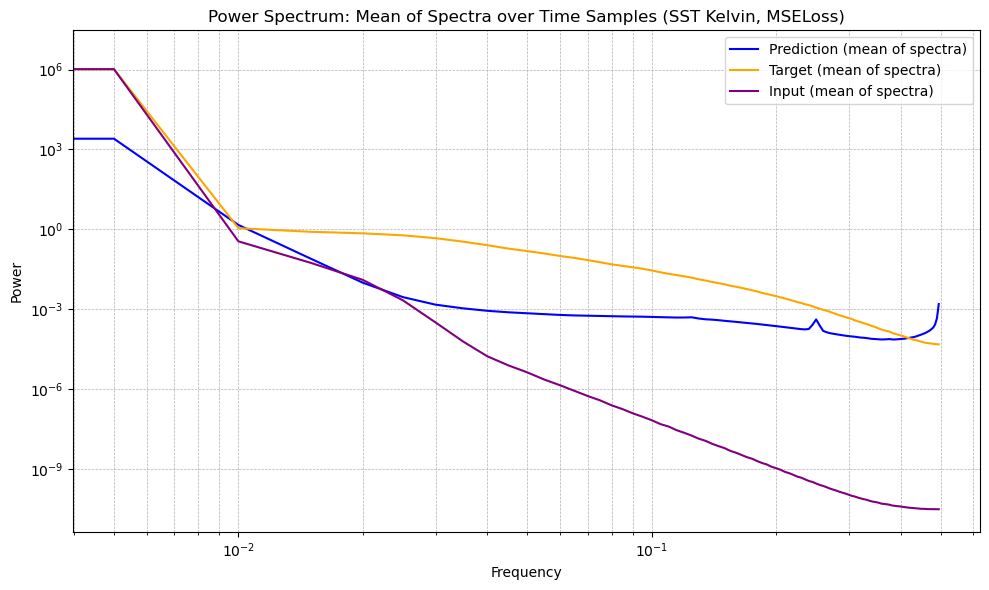

In [25]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(HR_test, dims, coords)
ps_input = mean_spectrum_over_samples(LR_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')
plt.plot(ps_input.freq_xt_ocean, ps_input, label='Input (mean of spectra)', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (SST Kelvin, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Case: SST in Celcius

In [15]:
# Extract HR data
HR_train = train_data_HR.surface_temp.values - 273.15 ## training
HR_val = val_data_HR.surface_temp.values - 273.15 ## validation
HR_test = test_data_HR.surface_temp - 273.15 ## testing

# Extract LR data
LR_train = train_data_LR.surface_temp.values - 273.15 ## training
LR_val = val_data_LR.surface_temp.values - 273.15 ## validation
LR_test = test_data_LR.surface_temp.values - 273.15 ## testing

In [16]:
x_train = torch.tensor(LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
# y_test = torch.tensor(HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [17]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_model(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_celcius_sst.pth',
            n_epochs=100) # n_epochs=2000)

Trainable Parameters: 2314881
Resuming from epoch 53 with best val losses [0.038263745024937006, 0.037658718303529494, 0.04765633992645719, 0.053956992548266684, 0.03615483422891809]
Epoch 54, Train Loss: 5.329e-01, Val Loss: 6.360e-01, Epoch Time: 139.88s
Patience counter: 1/50
Epoch 55, Train Loss: 4.571e-01, Val Loss: 4.053e-02, Epoch Time: 137.36s
Epoch 56, Train Loss: 3.572e-01, Val Loss: 6.141e-02, Epoch Time: 137.80s
Patience counter: 1/50
Epoch 57, Train Loss: 2.585e-01, Val Loss: 8.128e-01, Epoch Time: 137.77s
Patience counter: 2/50
Epoch 58, Train Loss: 2.684e-01, Val Loss: 7.322e-02, Epoch Time: 136.65s
Patience counter: 3/50
Epoch 59, Train Loss: 2.446e-01, Val Loss: 4.747e-02, Epoch Time: 137.50s
Epoch 60, Train Loss: 3.231e-01, Val Loss: 1.114e-01, Epoch Time: 137.62s
Patience counter: 1/50
Epoch 61, Train Loss: 4.133e-01, Val Loss: 4.186e-02, Epoch Time: 137.49s
Epoch 62, Train Loss: 2.473e-01, Val Loss: 9.631e-02, Epoch Time: 136.72s
Patience counter: 1/50
Epoch 63, Tra

In [18]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_celcius_sst.pth')
sr_pred

Loaded model parameters from ./model_celcius_sst.pth


<xarray.DataArray (time: 111, yt_ocean: 300, xt_ocean: 200)> Size: 27MB
array([[[21.611626 , 21.56437  , 21.438509 , ..., 22.088614 ,
         21.40348  , 20.38106  ],
        [22.37264  , 22.071827 , 22.204437 , ..., 21.712307 ,
         22.246534 , 21.09538  ],
        [22.812752 , 22.441792 , 21.853764 , ..., 22.09421  ,
         22.162521 , 22.195753 ],
        ...,
        [ 7.631187 ,  6.8845067,  7.067883 , ..., 10.516335 ,
         10.592731 , 10.48027  ],
        [ 7.568853 ,  6.3821287,  6.8306465, ..., 10.400284 ,
         10.255934 ,  9.358505 ],
        [ 7.027422 ,  6.2259603,  7.1461563, ..., 10.981003 ,
         10.730087 ,  9.09036  ]],

       [[20.146875 , 20.165949 , 19.805027 , ..., 22.391558 ,
         21.663536 , 20.537525 ],
        [20.261097 , 19.807096 , 19.99185  , ..., 21.985989 ,
         22.549246 , 21.27045  ],
        [20.54275  , 20.501541 , 19.91034  , ..., 22.33737  ,
         22.406107 , 22.385689 ],
...
        [ 8.839738 ,  8.606345 ,  8.005164 , ..., 11.425363 ,
         11.403209 , 11.415412 ],
        [ 8.838944 ,  9.021632 ,  7.6631255, ..., 11.313669 ,
         11.080213 , 10.149985 ],
        [ 9.379508 ,  8.804989 ,  9.058653 , ..., 11.691501 ,
         11.412054 ,  9.521595 ]],

       [[16.920382 , 17.297607 , 16.232832 , ..., 19.151754 ,
         19.22971  , 18.7601   ],
        [15.909355 , 15.440132 , 15.500087 , ..., 18.851624 ,
         19.45278  , 18.616941 ],
        [15.337602 , 16.089115 , 15.680628 , ..., 19.335566 ,
         19.41553  , 19.481674 ],
        ...,
        [ 4.2605405,  4.1160545,  4.0368176, ...,  3.5766144,
          3.5932539,  3.8869278],
        [ 4.3549423,  4.1223316,  4.236175 , ...,  3.7864735,
          3.9473689,  4.1042886],
        [ 4.2968483,  3.8232605,  4.1215954, ...,  4.0276823,
          4.1713195,  4.6155386]]], shape=(111, 300, 200), dtype=float32)
Coordinates:
  * time      (time) object 888B 0195-07-07 12:00:00 ... 0196-02-22 12:00:00
  * yt_ocean  (yt_ocean) float64 2kB 24.74 24.83 24.92 ... 48.26 48.33 48.39
  * xt_ocean  (xt_ocean) float64 2kB -169.9 -169.8 -169.7 ... -150.2 -150.1

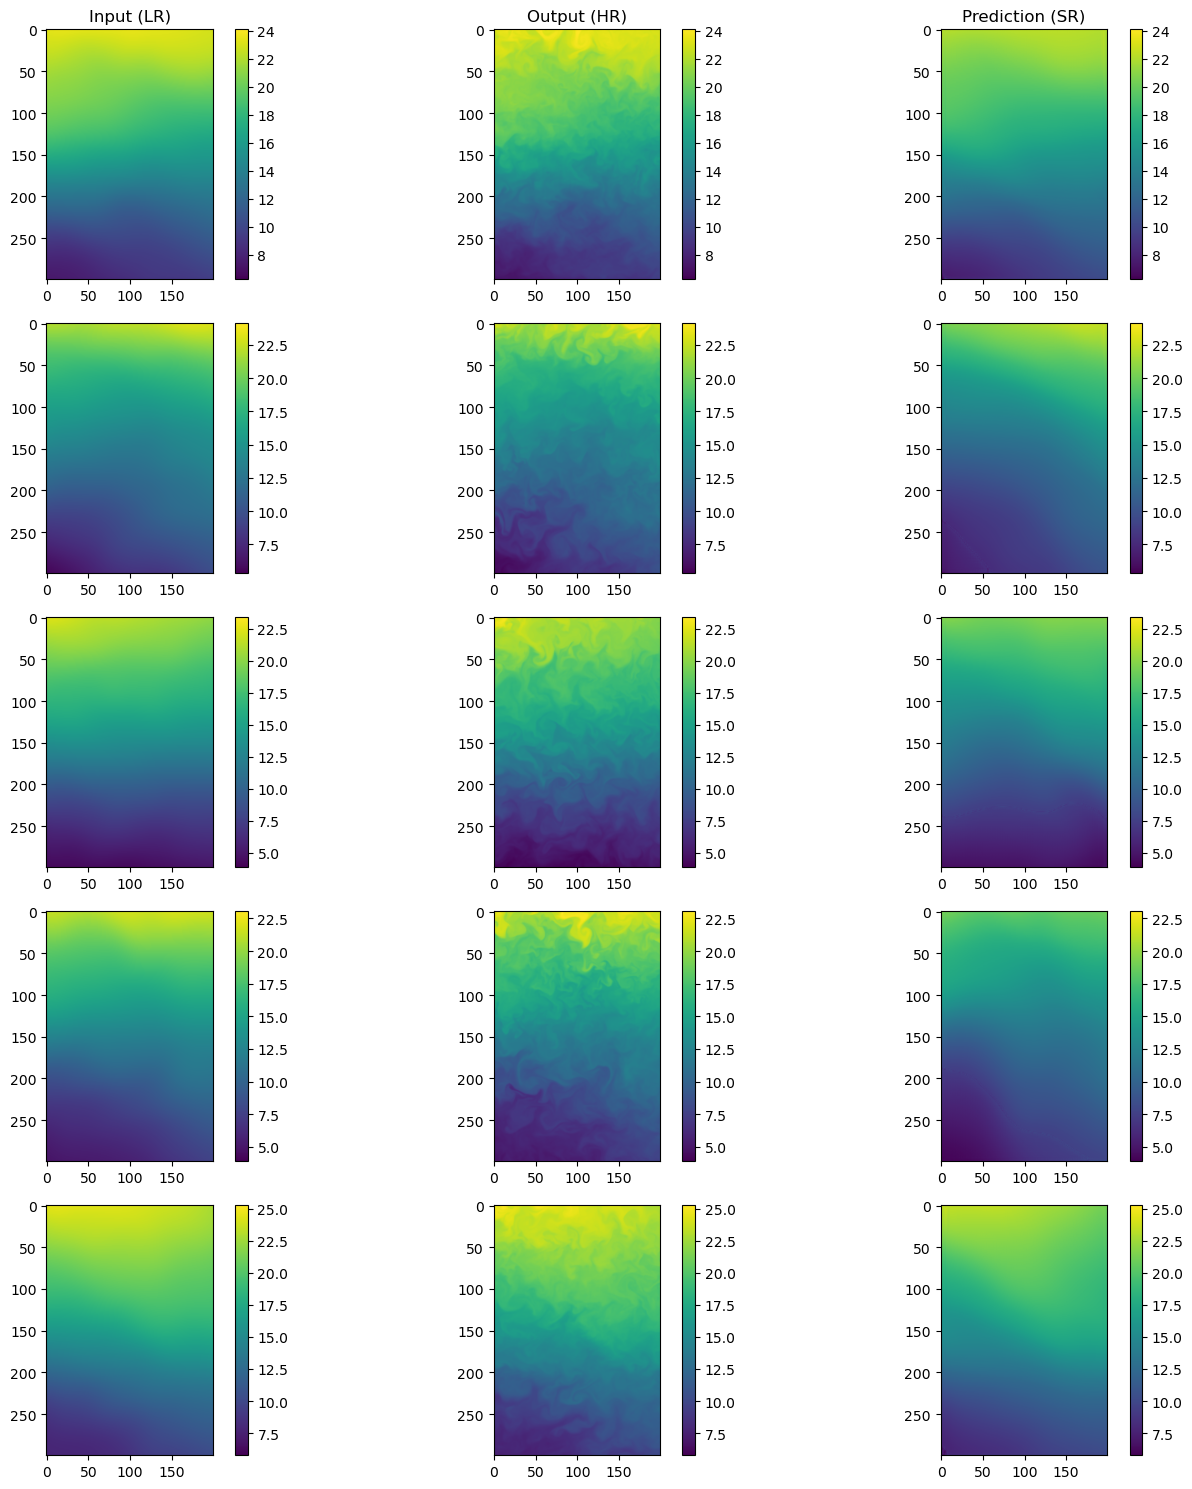

In [ ]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = LR_test[i,:,:] 
    d2 = HR_test[i,:,:]
    d3 = sr_pred[i,:,:]

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().compute().item(), d3.min().compute().item())
    vmax = max(d1.max().item(), d2.max().compute().item(), d3.max().compute().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

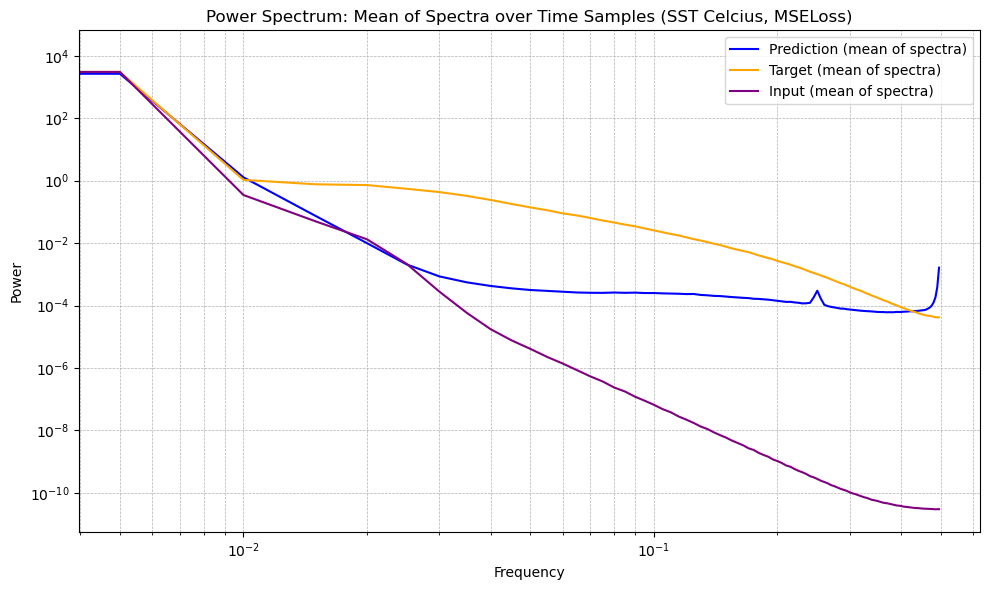

In [ ]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(sr_pred.shape[-2]),
    'xt_ocean': range(sr_pred.shape[-1])
}

# Function to compute average power spectrum across samples
def mean_spectrum_over_samples(data, dims, coords):
    ps_list = []
    for i in range(data.shape[0]):  # assuming dim 'time'
        sample = xr.DataArray(data[i], dims=dims, coords=coords).chunk({'xt_ocean': -1})
        ps = xrft.power_spectrum(sample, dim='xt_ocean', window=True).mean(dim='yt_ocean')
        ps_list.append(ps)
    return xr.concat(ps_list, dim='sample').mean(dim='sample')

# Compute averaged power spectra across samples
ps_pred = mean_spectrum_over_samples(sr_pred, dims, coords)
ps_targ = mean_spectrum_over_samples(HR_test, dims, coords)
ps_input = mean_spectrum_over_samples(LR_test, dims, coords)

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Prediction (mean of spectra)', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Target (mean of spectra)', color='orange')
plt.plot(ps_input.freq_xt_ocean, ps_input, label='Input (mean of spectra)', color='purple')

# Configure plot
plt.title("Power Spectrum: Mean of Spectra over Time Samples (SST Celcius, MSELoss)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()